In [ ]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne.datasets import eegbci
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [ ]:

subject = 'S001' # Example subject

root_dir = Path().resolve().parent
data_path = 'data/MNE-eegbci-data/files/eegmmidb/1.0.0/' + subject 
#file_names = os.listdir(os.path.join(root_dir, data_path))
file_names = ['S001R04.edf', 'S001R08.edf'] #using 2 datasets for training since we want to test on streamed data

tmin, tmax = -1.0, 4.0

# Load data
raw = concatenate_raws([read_raw_edf(os.path.join(root_dir, data_path, f), preload= True) for f in file_names])
eegbci.standardize(raw)
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
#raw.annotations.rename(dict(T1 = 'left', T2 = 'right')) #motor imagery of left and right hand

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")


picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, event_id = mne.events_from_annotations(raw)

epochs = Epochs(
    raw,
    events = events,
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2


In [ ]:
epochs_train.get_data().shape # trials x channels x samples

## Testing for other dataset

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) #changed these two lines
event_id = dict(hands=2, feet=3)

epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [32]:
labels.shape

(45,)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

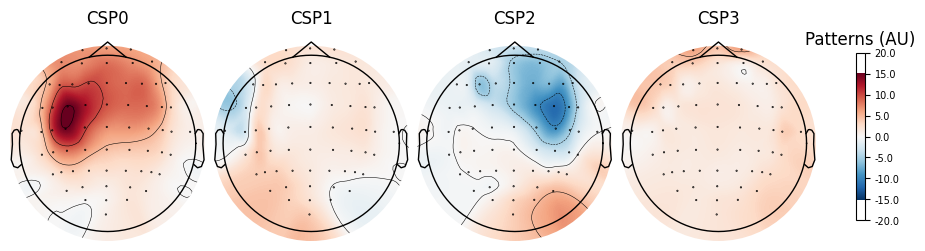

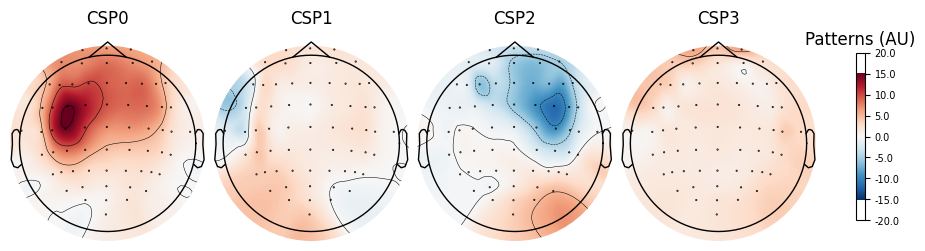

In [33]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [34]:
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Classification accuracy: 0.9333333333333333 / Chance level: 0.5333333333333333


In [35]:
#raw.compute_psd().plot()

In [36]:
#epochs_train.plot_image()

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

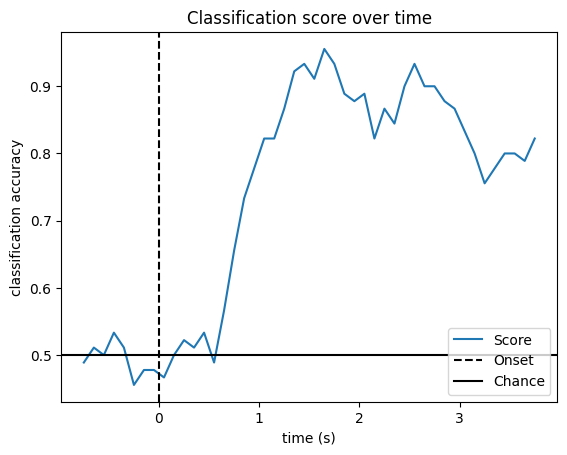

In [37]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [38]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [39]:
# cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
# get epochs
#epochs_data_train = 1e6 * epochs.get_data(copy=False) 

# compute covariance matrices
#cov_data_train = Covariances().transform(epochs_train)

In [40]:
# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Computing rank from data with rank=None


    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    M

In [41]:
import pywt

def extract_wavelet_features(epochs, sampling_freq, wavelet='db4', num_levels=4):
    """
    Extract wavelet features from EEG epochs.

    Args:
        epochs (np.ndarray): 3D array of EEG epochs with shape (n_epochs, n_channels, n_samples)
        sampling_freq (float): Sampling frequency of the EEG data
        wavelet (str): Name of the wavelet family to use (default: 'db4')
        num_levels (int): Number of wavelet decomposition levels (default: 4)

    Returns:
        np.ndarray: 2D array of wavelet features with shape (n_epochs, n_features)
    """
    n_epochs, n_channels, n_samples = epochs.shape
    features = []

    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel, wavelet, level=num_levels)

            # Extract features from the detail coefficients
            channel_features = []
            for level in range(num_levels):
                detail_coeffs = coeffs[level]
                channel_features.extend([
                    np.mean(np.abs(detail_coeffs)),  # Mean of absolute values
                    np.std(detail_coeffs),  # Standard deviation
                    np.max(np.abs(detail_coeffs)),  # Maximum of absolute values
                ])

            epoch_features.append(channel_features)

        epoch_features = np.concatenate(epoch_features)
        features.append(epoch_features)

    features = np.array(features)
    return features

In [42]:
#svm classifier
from sklearn.svm import SVC

# import numpy as np
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#wavelet_features = extract_wavelet_features(epochs_data, sampling_freq=epochs.info['sfreq'])

# 2. Create a custom transformer class for wavelet feature extraction
from sklearn.base import BaseEstimator, TransformerMixin

class WaveletTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return extract_wavelet_features(X, sampling_freq=epochs.info['sfreq'])


wavelet_transformer = WaveletTransformer()
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))


CSP + LDA Classification accuracy: 0.520000 / Chance level: 0.533333


In [43]:
# now try csp + svm
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)
print("CSP + SVM Classification accuracy: %f / Chance level: %f" %
        (np.mean(scores), class_balance))

Computing rank from data with rank=None


    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    M

## EEG Conformer


In [85]:
from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)
import mne

In [86]:
# 5, 6, 7, 10, 13, 14 are codes for executed and imagined hands/feet
subject_id = 1
event_codes = [6, 10, 14]
# event_codes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



# This will download the files if you don't have them yet,
# and then return the paths to the files.
physionet_paths = mne.datasets.eegbci.load_data(
    subject_id, event_codes, update_path=False)

# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True, stim_channel='auto')
         for path in physionet_paths]

In [87]:

descriptions = [{"event_code": code, "subject": subject_id}
                for code in event_codes]
windows_dataset = create_from_mne_raw(
    parts,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=200, #change this currently no overlap between windows
    window_stride_samples=200,
    drop_last_window=False,
    descriptions=descriptions,
)

c:\Users\Hannah\anaconda3\envs\eegdecoder\lib\site-packages\braindecode\preprocessing\windowers.py:124: UserWarning: Drop bad windows only has an effect if mne epochs are created, and this argument may be removed in the future.
  warnings.warn('Drop bad windows only has an effect if mne epochs are created, '
c:\Users\Hannah\anaconda3\envs\eegdecoder\lib\site-packages\braindecode\preprocessing\windowers.py:130: UserWarning: Using reject or picks or flat or dropping bad windows means mne Epochs are created, which will be substantially slower and may be deprecated in the future.
  warnings.warn('Using reject or picks or flat or dropping bad windows means '


In [88]:
splitted = windows_dataset.split('event_code')
train_set = splitted['6'] + splitted['10']  # train on runs 6 and 10
valid_set = splitted['14']  # test on run 14

In [89]:
train_set[0][0].shape[1]

200

In [90]:
import torch
from braindecode.util import set_random_seeds

import sys
# Adjust the path below as per your directory structure
sys.path.append('../models')

from eegconformer import EEGConformer

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_outputs = 3
classes = list(range(n_outputs))
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0] #64 channels
#input_window_samples = train_set[0][0].shape[1] # 480 timesteps
input_window_samples = 200

model = EEGConformer(
    n_outputs,
    n_chans,
    input_window_samples=input_window_samples,
    sfreq = 160)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model = model.cuda()

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 64, 200]              [1, 3]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 64, 200]           [1, 7, 40]                --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 64, 200]           [1, 40, 1, 7]             --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 64, 200]           [1, 40, 64, 176]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 64, 176]          [1, 40, 1, 176]           102,440                   [64, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 176]           [1, 40, 1, 176]           80             

c:\Users\Hannah\OneDrive\Documents\GitHub\eeg\notebooks\../models\base.py:23: UserWarning: EEGConformer: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Hannah\OneDrive\Documents\GitHub\eeg\notebooks\../models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [92]:
from skorch.callbacks import ProgressBar, Checkpoint, LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
mne.set_log_level('WARNING')

# We found these values to be good for the shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 1000

model_checkpoint = Checkpoint(f_params='model.pt', monitor='valid_loss_best')

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    classes = classes,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        #ProgressBar(),  # Shows a progress bar similar to tqdm
        model_checkpoint ,
    ],
    device=device,
)
# Model training for the specified number of epochs. `y` is None as it is
# already supplied in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss    cp      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ----  ------  ------
      1            0.5000        1.0539       0.5000            0.5000        1.0500     +  0.0006  1.0894
      2            0.5000        1.0756       0.5000            0.5000        1.0594        0.0006  1.1291
      3            0.5000        1.0667       0.5000            0.5000        1.0715        0.0006  1.1137
      4            0.2667        1.0572       0.2667            0.2667        1.1114        0.0006  1.0500
      5            0.2667        1.0831       0.2667            0.2667        1.1467        0.0006  1.0945
      6            0.2667        1.0587       0.2667            0.2667        1.1224        0.0006  1.0328
      7            0.2667        1.0394       0.2667            0.2667        1.0913        0.0006  1.1169
      8            0.5000        1.03

In [96]:
%matplotlib inline

In [100]:
np.max(clf.history[:, 'valid_accuracy'])

0.5666666666666667

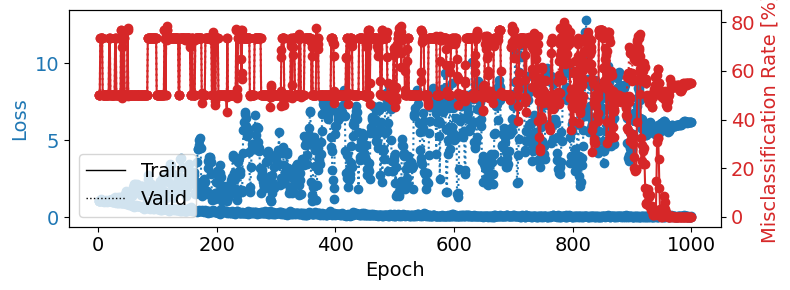

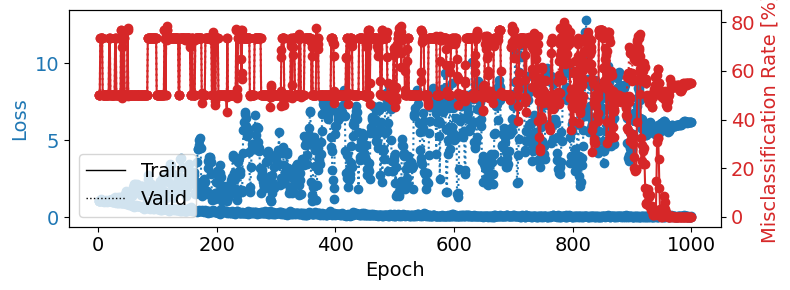

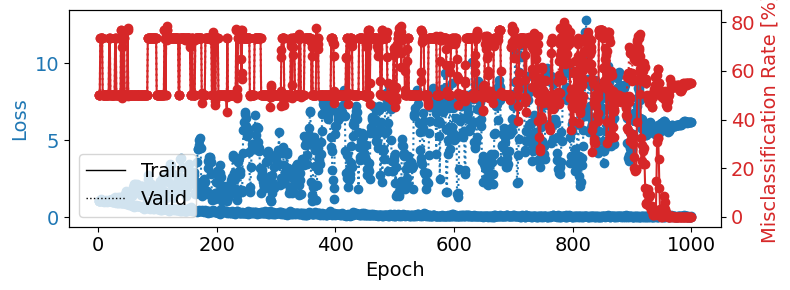

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

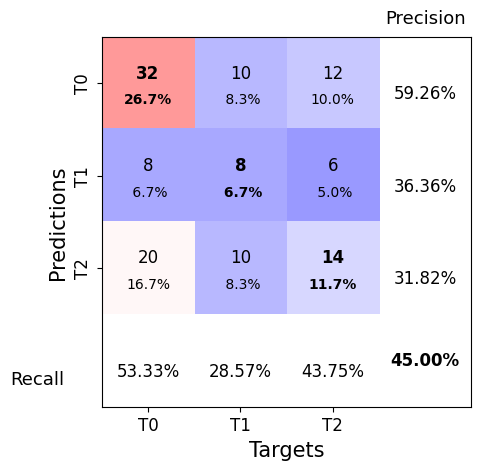

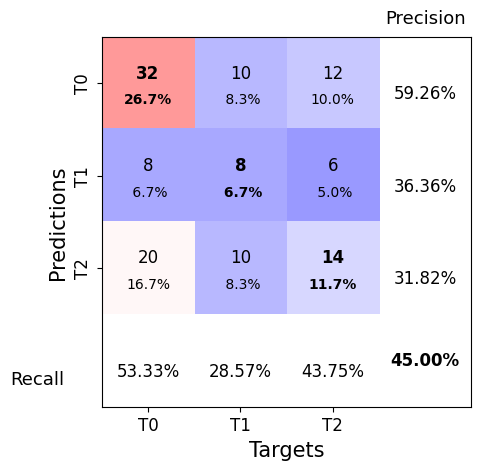

In [101]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)